![Vanna AI](https://img.vanna.ai/vanna-ask.svg)

The following notebook goes through the process of asking questions from your data using Vanna AI. Here we use a demo model that is pre-trained on the [TPC-H dataset](https://docs.snowflake.com/en/user-guide/sample-data-tpch.html) that is available in Snowflake.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vanna-ai/vanna-py/blob/main/notebooks/vn-ask.ipynb)

[![Open in GitHub](https://img.vanna.ai/github.svg)](https://github.com/vanna-ai/vanna-py/blob/main/notebooks/vn-ask.ipynb)

# Install Vanna
First we install Vanna from [PyPI](https://pypi.org/project/vanna/) and import it.
Here, we'll also install the Snowflake connector. If you're using a different database, you'll need to install the appropriate connector.

In [ ]:
%pip install vanna
%pip install snowflake-connector-python

In [2]:
import vanna as vn
import snowflake.connector

# Login
Creating a login and getting an API key is as easy as entering your email (after you run this cell) and entering the code we send to you. Check your Spam folder if you don't see the code.

In [3]:
api_key = vn.get_api_key('my-email@example.com')
vn.set_api_key(api_key)

# Set your Model
You need to choose a globally unique model name. Try using your company name or another unique string. All data from models are isolated - there's no leakage.

In [4]:
vn.set_model('tpc') # Enter your model name here. This is a globally unique identifier for your model.

# Set Database Connection
These details are only referenced within your notebook. These database credentials are never sent to Vanna's severs.

In [5]:
vn.connect_to_snowflake(account='my-account', username='my-username', password='my-password', database='my-database')

# Get Results
This gets the SQL, gets the dataframe, and prints them both. Note that we use your connection string to execute the SQL on your warehouse from your local instance. Your connection nor your data gets sent to Vanna's servers. For more info on how Vanna works, [see this post](https://medium.com/vanna-ai/how-vanna-works-how-to-train-it-data-security-8d8f2008042).

SELECT c.c_name as customer_name,
       sum(l.l_extendedprice * (1 - l.l_discount)) as total_sales
FROM   snowflake_sample_data.tpch_sf1.lineitem l join snowflake_sample_data.tpch_sf1.orders o
        ON l.l_orderkey = o.o_orderkey join snowflake_sample_data.tpch_sf1.customer c
        ON o.o_custkey = c.c_custkey
GROUP BY customer_name
ORDER BY total_sales desc limit 10;


,CUSTOMER_NAME,TOTAL_SALES
0,Customer#000143500,6757566.0218
1,Customer#000095257,6294115.3340
2,Customer#000087115,6184649.5176
3,Customer#000131113,6080943.8305
4,Customer#000134380,6075141.9635
5,Customer#000103834,6059770.3232
6,Customer#000069682,6057779.0348
7,Customer#000102022,6039653.6335
8,Customer#000098587,6027021.5855
9,Customer#000064660,5905659.6159


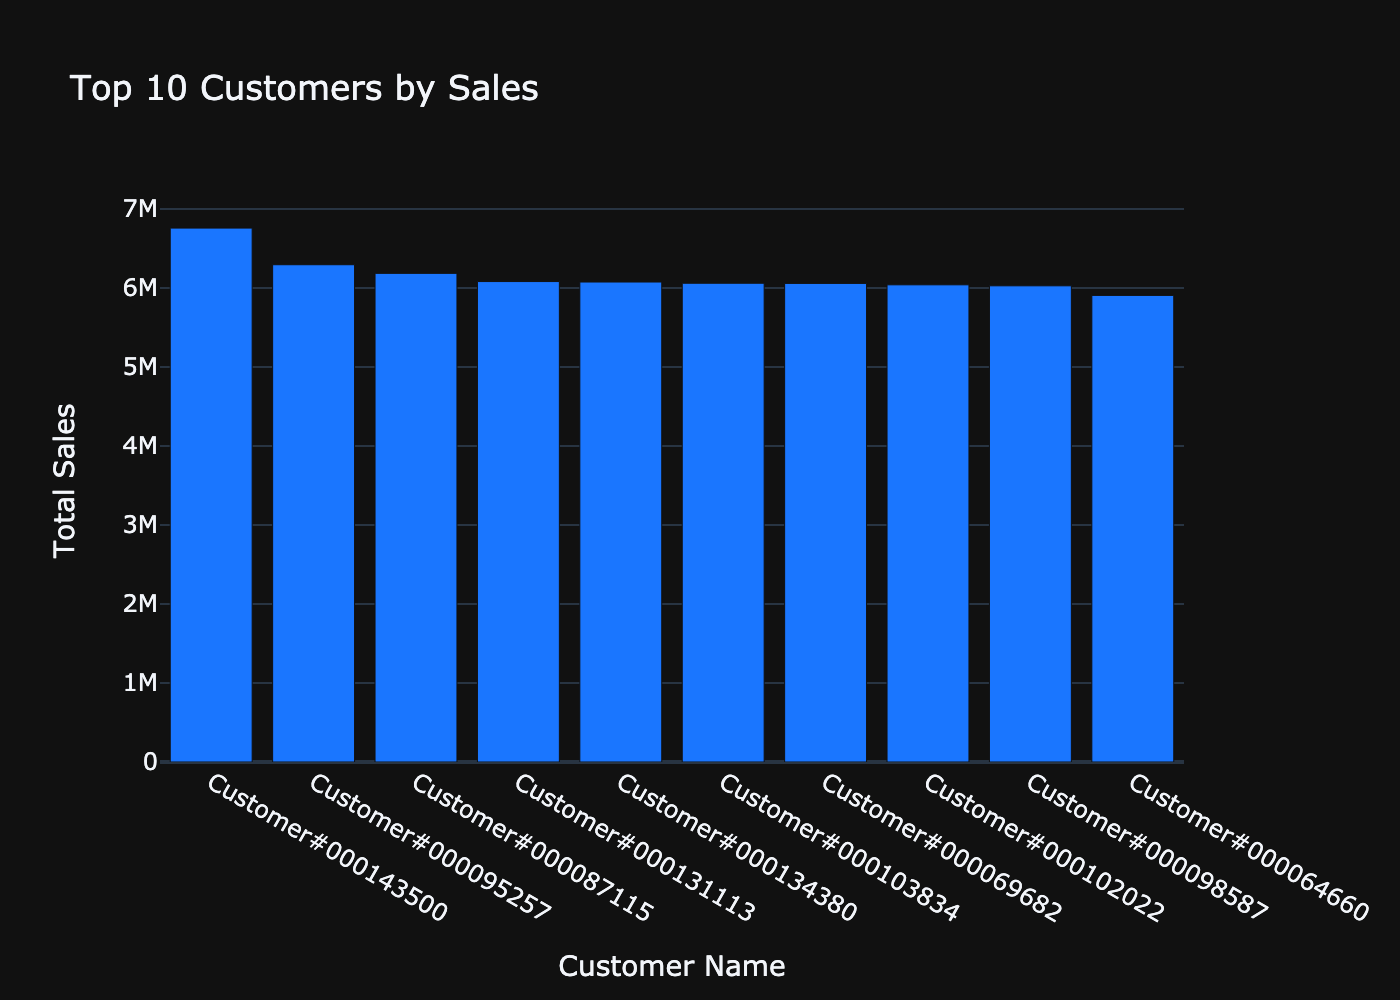

AI-generated follow-up questions:
What is the total sales value for each customer?
What are the names of the top 10 customers by sales in each country?
What is the total revenue for each country?
How many orders does each customer have?
What are the names of the top 10 customers by returned parts gross value?
What is the total sales value for the top 3 customers?
What are the names of the top 5 customers by sales in Europe?
How many customers are there in each country?
What is the returned parts gross value for each customer?
What is the total sales value for the top 3 customers?


In [6]:
vn.ask("What are the top 10 customers by sales?")

SELECT n.n_name as country_name,
       sum(l.l_extendedprice * (1 - l.l_discount)) as total_sales
FROM   snowflake_sample_data.tpch_sf1.nation n join snowflake_sample_data.tpch_sf1.customer c
        ON n.n_nationkey = c.c_nationkey join snowflake_sample_data.tpch_sf1.orders o
        ON c.c_custkey = o.o_custkey join snowflake_sample_data.tpch_sf1.lineitem l
        ON o.o_orderkey = l.l_orderkey
GROUP BY country_name
ORDER BY total_sales desc limit 5;


,COUNTRY_NAME,TOTAL_SALES
0,FRANCE,8960205391.8314
1,INDONESIA,8942575217.6237
2,RUSSIA,8925318302.0710
3,MOZAMBIQUE,8892984086.0088
4,JORDAN,8873862546.7864


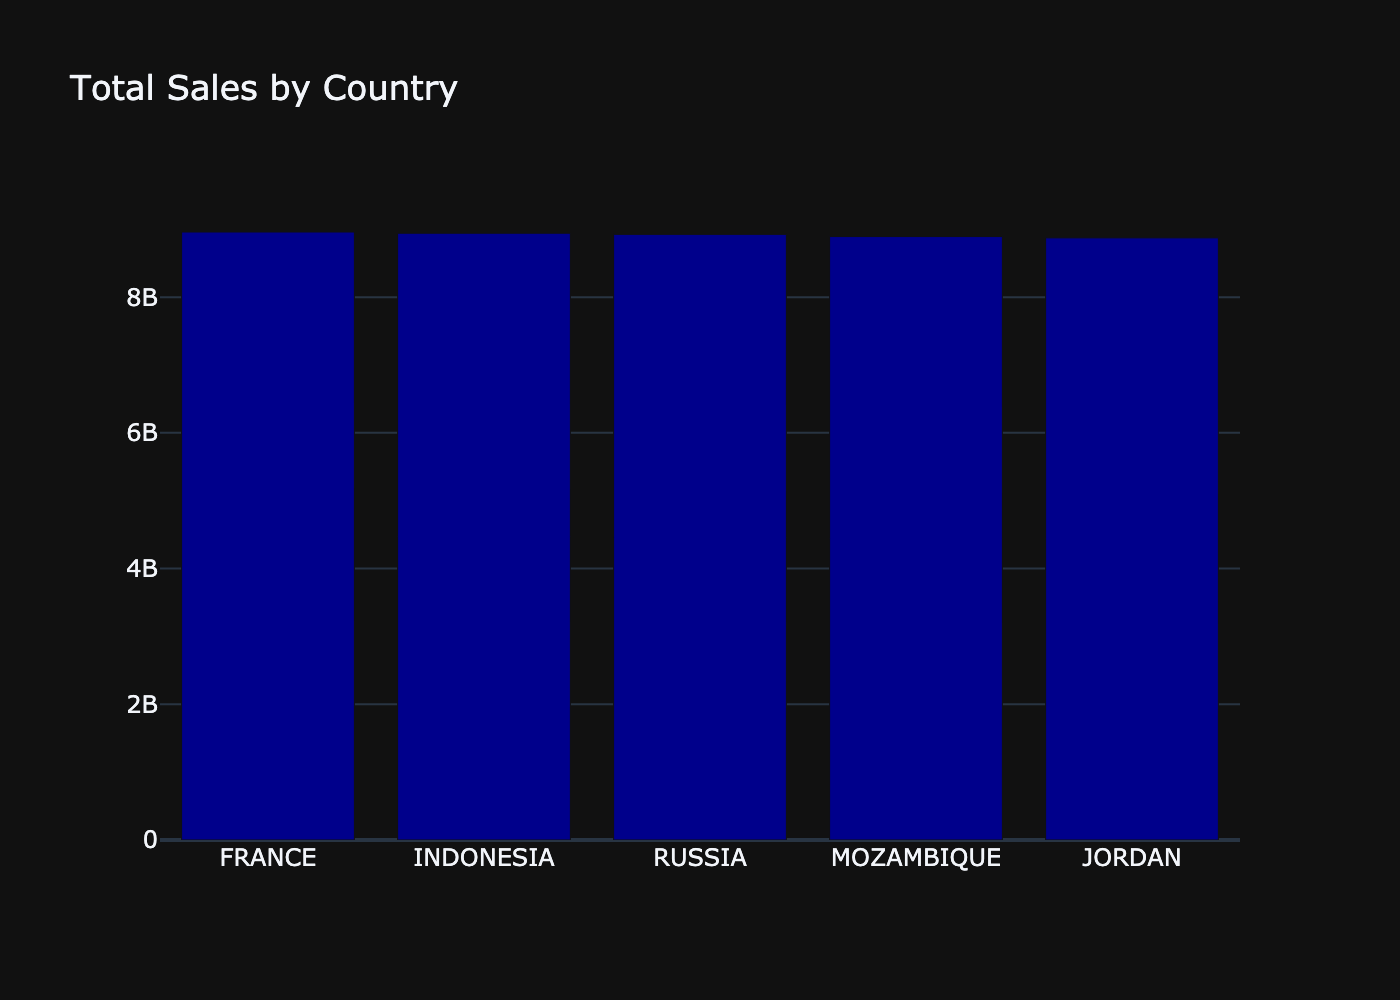

AI-generated follow-up questions:
What are the total sales for each country in descending order?
How many customers are there in each of the top 5 countries with the highest sales?
What are the top 5 customers with the highest sales?
How does the sales distribution vary across different regions?
What is the total sales for each customer in the United States?
How many orders were placed by each customer in each country?
What is the total revenue for each customer in each country?
What is the total sales for each customer in Europe?
What is the total order amount for each country in descending order?
Which country has the highest number of failed orders?
Who are the top 3 customers with the highest sales?


In [7]:
vn.ask("Which 5 countries have the highest sales?")

with ranked_customers as (SELECT c.c_name as customer_name,
                                 r.r_name as region_name,
                                 row_number() OVER (PARTITION BY r.r_name
                                                    ORDER BY sum(l.l_quantity * l.l_extendedprice) desc) as rank
                          FROM   snowflake_sample_data.tpch_sf1.customer c join snowflake_sample_data.tpch_sf1.orders o
                                  ON c.c_custkey = o.o_custkey join snowflake_sample_data.tpch_sf1.lineitem l
                                  ON o.o_orderkey = l.l_orderkey join snowflake_sample_data.tpch_sf1.nation n
                                  ON c.c_nationkey = n.n_nationkey join snowflake_sample_data.tpch_sf1.region r
                                  ON n.n_regionkey = r.r_regionkey
                          GROUP BY customer_name, region_name)
SELECT region_name,
       customer_name
FROM   ranked_customers
WHERE  rank <= 2;


,REGION_NAME,CUSTOMER_NAME
0,ASIA,Customer#000102022
1,ASIA,Customer#000148750
2,AMERICA,Customer#000095257
3,AMERICA,Customer#000091630
4,EUROPE,Customer#000028180
5,EUROPE,Customer#000053809
6,MIDDLE EAST,Customer#000143500
7,MIDDLE EAST,Customer#000103834
8,AFRICA,Customer#000131113
9,AFRICA,Customer#000134380


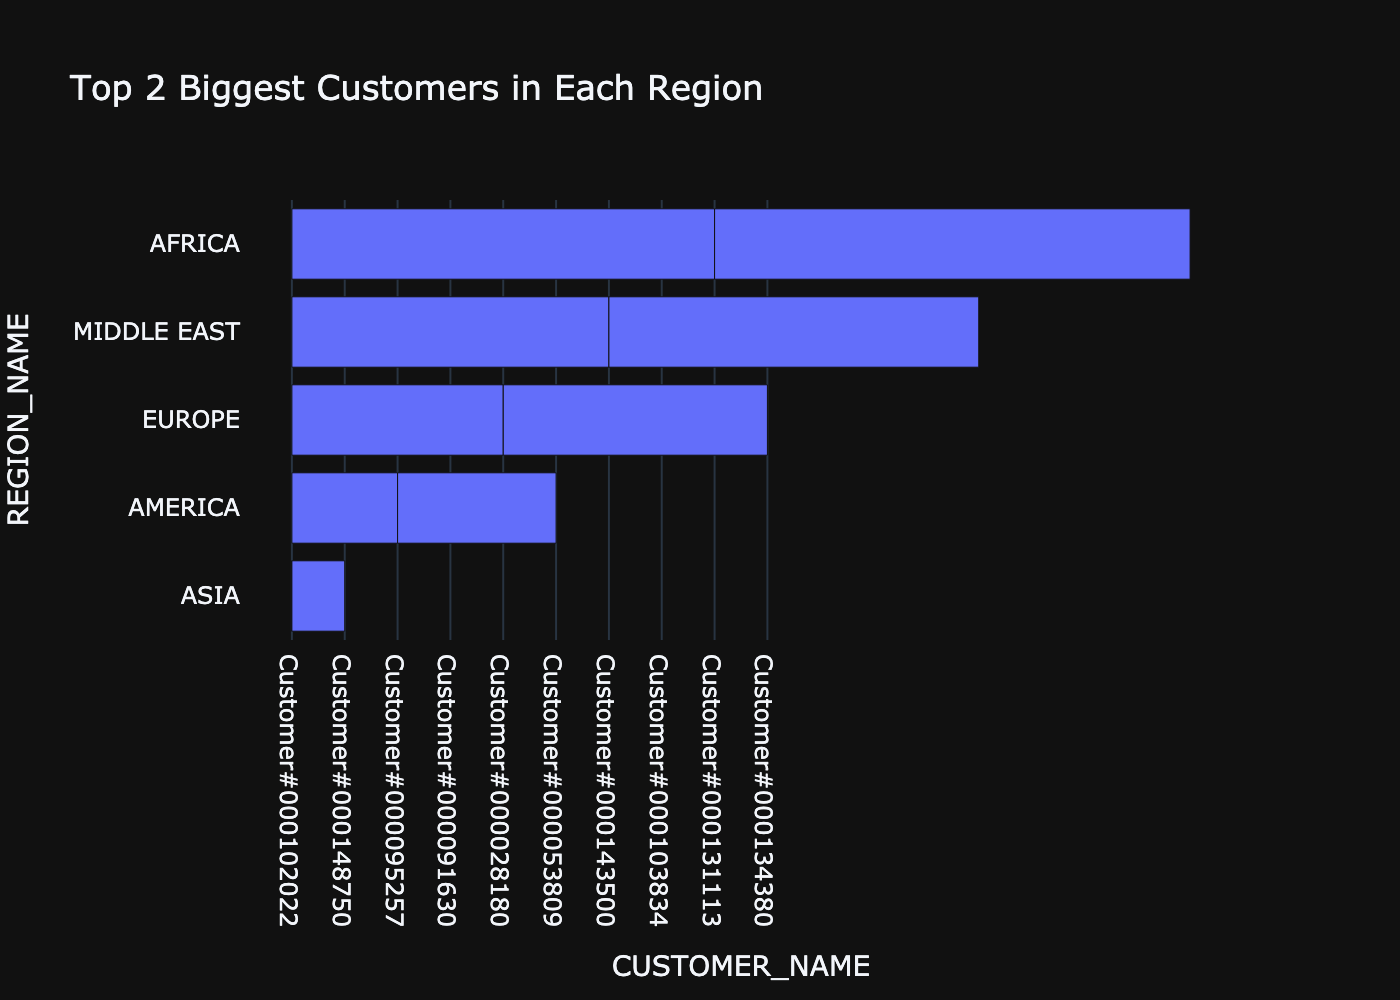

In [ ]:
vn.ask("Who are the top 2 biggest customers in each region?")

# Run as a Web App
If you would like to use this functionality in a web app, you can deploy the Vanna Streamlit app and use your own secrets. See [this repo](https://github.com/vanna-ai/vanna-streamlit).